In [1]:
import os
from tabulate import tabulate
from tqdm.auto import tqdm
from datetime import datetime

import numpy as np

import torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt

KeyError: 'results'

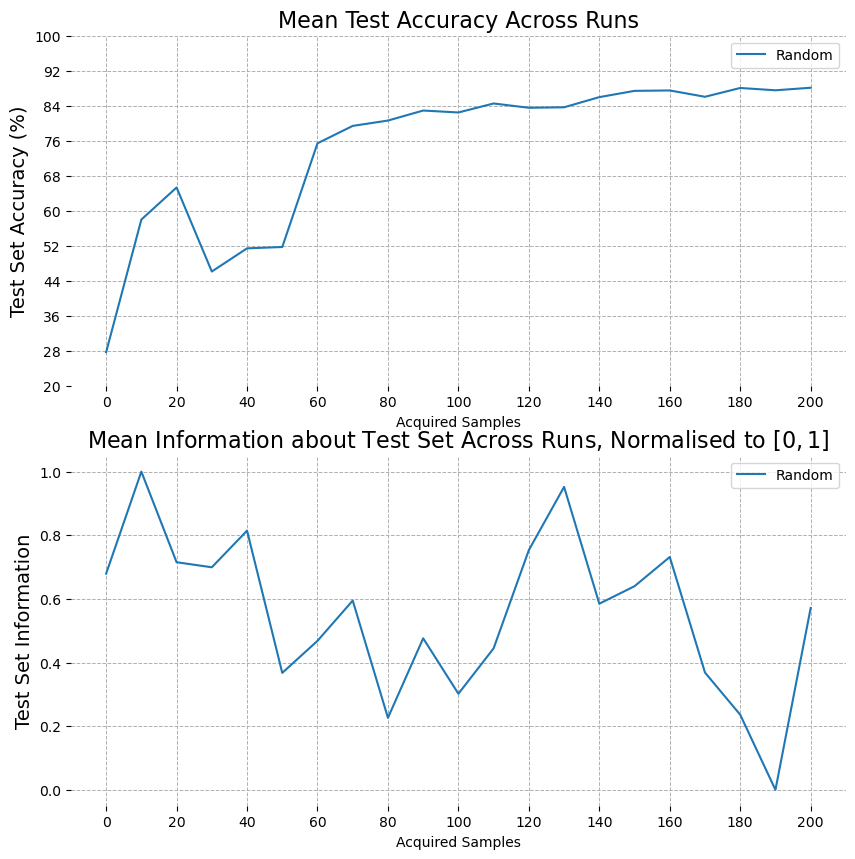

In [2]:
from utils import visualise_active_learning_experiments
import pickle

save_path = './Experiment Results/expID-20240907_221225'
with open(save_path, 'rb') as handle:
    loaded_experiment_results = pickle.load(handle)

visualise_active_learning_experiments(loaded_experiment_results)

In [4]:
TRAIN_SIZE = 20
VAL_SIZE = 100
POOL_SIZE = 60_000 - (TRAIN_SIZE + VAL_SIZE)
print(f"train size: {TRAIN_SIZE:_}, val size: {VAL_SIZE:_}, pool size: {POOL_SIZE:_}")

DATA_PATH = '/Users/pascalpilz/Documents/Bsc Thesis/data/mnist/'
MODEL_SAVE_PATH = '/Users/pascalpilz/Documents/Bsc Thesis/models/'

SEED = 1

torch.manual_seed(SEED)
np.random.seed(SEED)

train size: 20, val size: 100, pool size: 59_880


# Data Loading

In [5]:
def visualise_datasets(X_train, y_train, X_pool, y_pool,
                       X_val, y_val, X_test, y_test):
    # show each dataset size, mean, std in a nice table
    print(tabulate([ [name, len(ds), ds.mean(), ds.std()] for name, ds in
                     [('train', X_train), ('pool', X_pool), ('val', X_val), ('test', X_test)] ],
                   floatfmt='.3f', intfmt='_', headers=['size', 'mean', 'std']))
    
    # show each dataset distribution of labels in one histogram
    fig, axs = plt.subplots(1, 1, figsize=(10, 3))
    axs.hist([y_train, y_val, y_pool, y_test], bins=range(0, 11),
             density=True, label=['train', 'val', 'pool', 'test'])
    axs.axhline(y=0.1, color='r', linestyle='--', alpha=0.6)
    plt.xticks(np.linspace(0.5, 9.5, 10), np.arange(0, 10))
    plt.legend(loc='lower right')
    fig.suptitle('Label Distribution per Dataset', fontsize=16)
    plt.show()
    
    # Show images of entire initial training set. Only consists of 20 images, two of each class
    fig, axs = plt.subplots(2, 10, figsize=(10, 3))
    for i in range(2):
        for j in range(10):
            ax = axs[i, j]
            ax.imshow(X_train[i + j*2].squeeze(), cmap='gray')
            if i == 0:
                ax.set_title(f'{y_train[i + j*2].item()}')
            ax.axis('off')
    fig.suptitle('Initial Training Set', fontsize=16)
    plt.tight_layout()
    plt.show()
    
def get_datasets(train_size=TRAIN_SIZE,
                 pool_size=POOL_SIZE,
                 val_size=VAL_SIZE,
                 data_path=DATA_PATH):

    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         # we pad because the images are 28x28 but the network expects 32x32
         torchvision.transforms.Pad(2),
         # 0.10003718 and 0.2752173 is mean and std respectively of train set after padding
         # (without padding it is 0.1307 and 0.3081 mean and std respectively)
         torchvision.transforms.Normalize((0.10003718,), (0.2752173,))])
    
    # getting the test and train set
    train_val_set = torchvision.datasets.MNIST(root=data_path, train=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root=data_path, train=False, transform=transform)
    
    # splitting train further into train and val
    train_set, val_set = torch.utils.data.random_split(train_val_set, [train_size + pool_size, val_size])
    
    # creating data loaders
    # having batch size equal to the size of the dataset to get the whole dataset in one batch
    # enables us to get the whole dataset at once when iterating over the loader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)
    
    X_train_all, y_train_all = next(iter(train_loader))
    X_val, y_val = next(iter(val_loader))
    X_test, y_test = next(iter(test_loader))
    
    # creating a random but balanced initial training set and pool from remaining train data
    idx = []
    for num in range(10):
        indices = torch.where(y_train_all == num)[0]
        idx += list(np.random.choice(indices, 2, replace=False))
    idx = torch.tensor(idx)

    X_train = X_train_all[idx]
    y_train = y_train_all[idx]

    # pool is all samples from full training set that weren't chosen for initial training set
    X_pool = X_train_all[~torch.isin(torch.arange(len(X_train_all)), idx)]
    y_pool = y_train_all[~torch.isin(torch.arange(len(X_train_all)), idx)]
    
    return X_train, y_train, X_pool, y_pool, X_val, y_val, X_test, y_test

         size    mean    std
-----  ------  ------  -----
train      20   0.028  1.033
pool   59_880  -0.000  1.000
val       100  -0.004  0.997
test   10_000   0.005  1.008


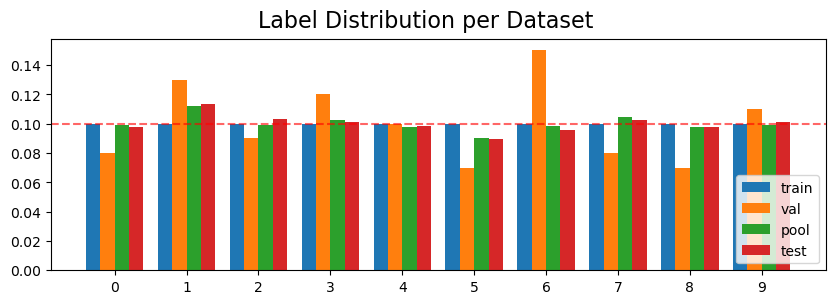

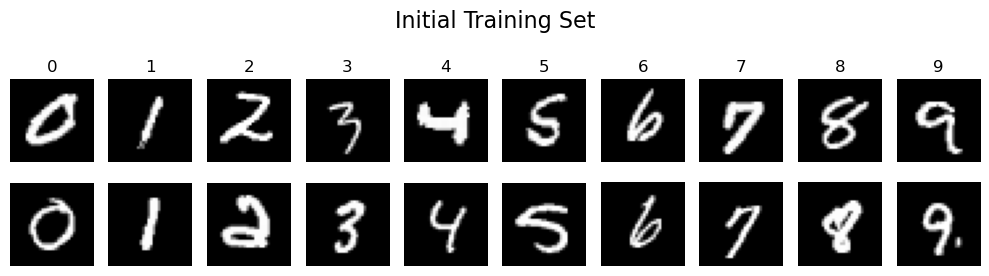

In [6]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# get dataset, these are given as torch tensors
X_train, y_train, X_pool, y_pool, X_val, y_val, X_test, y_test = get_datasets()

# get val and test set and loader now
# train and pool we get when we need since they change constantly
val_set = torch.utils.data.TensorDataset(X_val, y_val)
test_set = torch.utils.data.TensorDataset(X_test, y_test)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True)

# Printing and visualising some useful information
visualise_datasets(X_train, y_train, X_pool, y_pool, X_val, y_val, X_test, y_test)

# Model

In [7]:
class LeNet(nn.Module):
    
    def __init__(self):
         super(LeNet, self).__init__()
         self.conv1 = nn.Conv2d(1, 6, 5)
         self.conv2 = nn.Conv2d(6, 16, 5)
         self.pool = nn.MaxPool2d(2)
         self.do1 = nn.Dropout(0.25)  # 0.25 chosen as in Gal et al. 2016
         self.do2 = nn.Dropout(0.5)  # 0.5 chosen as in Gal et al. 2016
         self.fc1 = nn.Linear(16 * 5 * 5, 120)  # images are 5x5 with 16 channels
         self.fc2 = nn.Linear(120, 84)
         self.fc3 = nn.Linear(84, 10)
         
    def forward(self, x):               # x.shape = (b, 32, 32), where b is batch size
        c1 = F.relu(self.conv1(x))      # c1.shape = (b, 6, 28, 28)
        p2 = self.pool(c1)              # p2.shape = (b, 6, 12, 12)
        c3 = F.relu(self.conv2(p2))     # c3.shape = (b, 16, 10, 10)
        p4 = self.pool(c3)              # p4.shape = (b, 16, 5, 5)
        p5 = torch.flatten(p4, 1)       # p5.shape = (b, 16*5*5) = (b, 400)
        d6 = self.do1(p5)               # d6.shape = (b, 400)
        f7 = F.relu(self.fc1(d6))       # f6.shape = (b, 120)
        d8 = self.do2(f7)               # d8.shape = (b, 12)
        f9 = F.relu(self.fc2(d8))       # f9.shape = (b, 84)
        output = self.fc3(f9)           # output.shape = (b, 10)
        return output

# Training and Testing Functions

In [6]:
def train_one_epoch(model,
                    train_loader,
                    optimizer,
                    loss_fn,
                    print_at=1000,
                    verbose=False):
    
    running_loss = 0.
    last_loss = 0.

    for i, (inputs, labels) in enumerate(train_loader):

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % print_at == print_at-1:
            last_loss = running_loss / print_at # loss per batch
            if verbose:
                print(f'  batch {i + 1:7_d} train loss: {last_loss:6.4f}')
            running_loss = 0.

    return last_loss

def run_training(model,
                 train_loader,
                 val_loader,
                 optimizer,
                 loss_fn,
                 print_at=-1,
                 n_epochs=5,
                 verbose=False,
                 early_stopping=10):
    
    # if print_at is -1 then we just print 5 times during training
    if print_at == -1:
        print_at = max(len(train_loader) // 5, 1)
    save_path = None

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_path = MODEL_SAVE_PATH + str(timestamp) + '/'
    os.makedirs(model_path, exist_ok=True)

    epochs_since_best_vloss = 0
    best_vloss = np.inf
    
    epochs = tqdm(desc=f'Training Epochs with Training size {len(train_loader.dataset)}', leave=False)
    # epochs = tqdm(range(n_epochs), desc=f'Training size {len(train_loader.dataset)}')
    for epoch in range(n_epochs):
    
        model.train(True)
        avg_loss = train_one_epoch(model=model,
                                   train_loader=train_loader,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   print_at=print_at,
                                   verbose=verbose)
        
        # get validation loss
        running_vloss = 0.0
        model.eval()
    
        with torch.no_grad():
            for i, (vinputs, vlabels) in enumerate(val_loader):
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss
    
        avg_vloss = running_vloss / (i + 1)
        if verbose:
            print(f'LOSS train {avg_loss:6.5f} valid {avg_vloss:6.4f}\n')
    
        # track the best performance, and save the model's state. Early stopping if no improvement for certain number of epochs
        if avg_vloss < best_vloss:
            epochs_since_best_vloss = 0
            best_vloss = avg_vloss
            save_path = model_path + f'model_{timestamp}_{epoch}'
            torch.save(model.state_dict(), save_path)
        else:
            epochs_since_best_vloss += 1
            if epochs_since_best_vloss == early_stopping:
                if verbose:
                    print(f'Early stopping at epoch {epoch}.')
                break

        epochs.update()
    epochs.close()
    if verbose:
        print('Done.')
    return save_path

def get_accuracy(model, dataloader):
    
    model.eval()
    running_corrects = 0
    predications = []
    
    for i, (inputs, labels) in enumerate(dataloader):
        toutputs = model(inputs)
        toutputs = torch.argmax(toutputs, dim=1)
        running_corrects += torch.sum(torch.Tensor(toutputs == labels.data))
        predications += toutputs.tolist()
        
    acc = running_corrects.float() / (len(dataloader) * 4)

    return acc

# Acquisition Functions

In [7]:
def perform_acquisition(model, acquisition_function,
                        X_train, y_train, X_pool, y_pool,
                        n_samples_to_acquire=10):
    idx = acquisition_function(model, X_pool, n_samples_to_acquire=n_samples_to_acquire)
    
    chosen_X_pool = X_pool[idx]
    chosen_y_pool = y_pool[idx]
    
    new_X_train = torch.concatenate([X_train, chosen_X_pool], 0)
    new_y_train = torch.concatenate([y_train, chosen_y_pool], 0)
    
    new_X_pool = X_pool[~torch.isin(torch.arange(len(X_pool)), idx)]
    new_y_pool = y_pool[~torch.isin(torch.arange(len(y_pool)), idx)]
    
    return new_X_train, new_y_train, new_X_pool, new_y_pool

def random(model, X_pool, n_samples_to_acquire=10):
    idx = np.random.choice(range(len(X_pool)), size=n_samples_to_acquire, replace=False)
    idx = torch.from_numpy(idx)
    return idx

# Experiments

## Training on Full Dataset

In [8]:
torch.manual_seed(SEED)
np.random.seed(SEED)

net = LeNet()

optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

# recombine train, pool, and val set to train on the full dataset
# train_set = torch.utils.data.TensorDataset(
#     torch.concatenate([X_train, X_pool, X_val], 0),
#     torch.concatenate([y_train, y_pool, y_val], 0))

# use only initial training set of 20 examples
train_set = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)

path = run_training(net,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    n_epochs=100,
                    early_stopping=5,
                    verbose=False)

# path = MODEL_SAVE_PATH + '20240830_181057/model_20240830_181057_0model_20240830_181057_2'
best_model = LeNet()
best_model.load_state_dict(torch.load(path, weights_only=True))
acc = get_accuracy(best_model, test_loader)
print('\n' + '='*75)
print(f'Model with lowest val loss found in epoch {path.split('_')[-1]}, test accuracy: {100*acc:6.2f}%')

Training Epochs with Training size 20: 0it [00:00, ?it/s]


Model with lowest val loss found in epoch 60, test accuracy:  48.71%


## Active Learning

In [9]:
def run_active_learning(X_train, y_train, X_pool, y_pool, val_loader, test_loader,
                        acquisition_function, n_acquisition_steps=100, n_samples_to_acquire=10,
                        n_epochs=100, verbose=False, training_verbose=False):
    
    running_X_train = X_train
    running_y_train = y_train
    
    running_X_pool = X_pool
    running_y_pool = y_pool
    
    results = {'acq step': [], 'train size': [], 'acc': []}
    
    # do 50 acquisition steps
    for i in tqdm(range(n_acquisition_steps), desc='Acquisition Steps', leave=False):
        
        net = LeNet()
        optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        loss_fn = torch.nn.CrossEntropyLoss()
    
        running_train_set = torch.utils.data.TensorDataset(running_X_train, running_y_train)
        running_train_loader = torch.utils.data.DataLoader(running_train_set, batch_size=4, shuffle=True)
        
        path = run_training(net,
                            train_loader=running_train_loader,
                            val_loader=val_loader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            n_epochs=n_epochs,
                            early_stopping=10,
                            verbose=training_verbose)
    
        # loading the model with the lowest val loss to get accuracy on test set
        best_model = LeNet()
        best_model.load_state_dict(torch.load(path, weights_only=True))
        acc = get_accuracy(best_model, test_loader)
        results['acq step'].append(i)
        results['train size'].append(running_X_train.shape[0])
        results['acc'].append(acc)
        
        if verbose:
            print('\n' + '='*75)
            print(f'Acquisition step {i:3d} - train size: {running_X_train.shape[0]:6_d}, test accuracy: {acc:6.4f}')
            print('\n')
        
        running_X_train, running_y_train, running_X_pool, running_y_pool\
            = perform_acquisition(model=net, acquisition_function=acquisition_function, n_samples_to_acquire=n_samples_to_acquire,
                                  X_train=running_X_train, y_train=running_y_train, X_pool=running_X_pool, y_pool=running_y_pool)
        
    results = {key: torch.Tensor(val) for key, val in results.items()}
    return results

### Random

In [10]:
torch.manual_seed(SEED)
np.random.seed(SEED)

random_params = {'acquisition_function': random,
                 'n_acquisition_steps': 2,
                 'n_samples_to_acquire': 10,
                 'n_epochs': 100
                 }
experiments = [random_params]

for experiment in tqdm(experiments, desc='Experiments'):
    # for each experiment we perform three runs and average the results
    runs = []
    
    for run in tqdm(range(2), desc='Runs per Experiment', leave=False):
        results = run_active_learning(X_train, y_train, X_pool, y_pool, val_loader, test_loader, **experiment)
        runs.append(results)

    experiment['runs'] = runs

Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

Runs per Experiment:   0%|          | 0/2 [00:00<?, ?it/s]

Acquisition Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Training Epochs with Training size 20: 0it [00:00, ?it/s]

Training Epochs with Training size 30: 0it [00:00, ?it/s]

Acquisition Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Training Epochs with Training size 20: 0it [00:00, ?it/s]

Training Epochs with Training size 30: 0it [00:00, ?it/s]

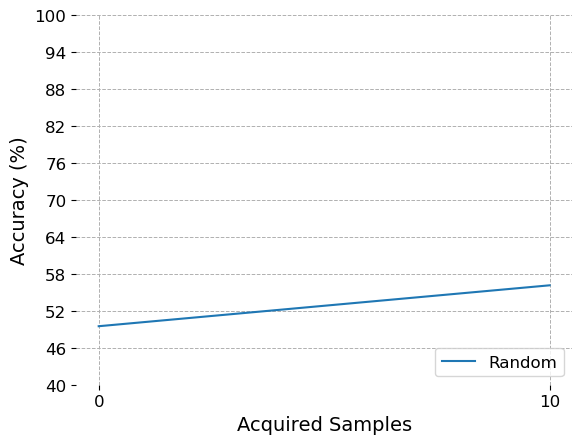

In [11]:
def visualise_active_learning_experiments(experiments, train_size=TRAIN_SIZE):
    
    for experiment in experiments:
        
        runs = experiment['runs']
        n_acq_steps = experiment['n_acquisition_steps']
        name = experiment['acquisition_function'].__name__
        
        # we show the mean of all the runs that were done, usually it's 3 runs
        x = np.array(runs[0]['train size']) - train_size
        y = np.mean([run['acc'] for run in runs], axis=0) * 100 + np.random.normal(1, 1)
        
        plt.plot(x, y, label=name.title())
        
        # turn off the border
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        plt.grid(True, which='both', linestyle='--', linewidth=0.7)
        
        plt.xticks(ticks=np.linspace(0, x.max(), n_acq_steps), fontsize=12)
        plt.yticks(ticks=np.linspace(np.floor(y.min()/10)*10, 100, 11), fontsize=12)
        plt.legend(loc='lower right', fontsize=12)
        plt.xlabel('Acquired Samples', fontsize=14)
        plt.ylabel('Accuracy (%)', fontsize=14)
    
    plt.show()
    
visualise_active_learning_experiments(experiments)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # images are 5x5 with 16 channels
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, use_dropout=False):                 # x.shape = (b, 32, 32), where b is batch size
        c1 = F.relu(self.conv1(x))                          # c1.shape = (b, 6, 28, 28)
        p2 = self.pool(c1)                                  # p2.shape = (b, 6, 12, 12)
        c3 = F.relu(self.conv2(p2))                         # c3.shape = (b, 16, 10, 10)
        p4 = self.pool(c3)                                  # p4.shape = (b, 16, 5, 5)
        p5 = torch.flatten(p4, 1)                           # p5.shape = (b, 16*5*5) = (b, 400)
        d6 = F.dropout(p5, p=0.25, training=use_dropout)    # d6.shape = (b, 400)
        f7 = F.relu(self.fc1(d6))                           # f6.shape = (b, 120)
        d8 = F.dropout(f7, p=0.5, training=use_dropout)     # d8.shape = (b, 12)
        f9 = F.relu(self.fc2(d8))                           # f9.shape = (b, 84)
        output = self.fc3(f9)                               # output.shape = (b, 10)
        return output

In [116]:
def get_accuracy(model, dataloader):
    model.eval()
    running_corrects = 0
    predications = []

    for i, (inputs, labels) in enumerate(dataloader):
        # outputs = model(inputs, use_dropout=True)
        outputs = model(inputs, use_dropout=True)
        outputs = torch.argmax(outputs, dim=1)
        running_corrects += torch.sum(torch.Tensor(outputs == labels.data))
        predications += outputs.tolist()

    acc = running_corrects.float() / (len(dataloader) * 4)

    return acc

def dropout_approximation(model, dataloader, T=100):
    
    model.eval()
    preds = []
    means = []
    vars = []
    entropies = []
    mutual_infos = []
    
    for i, (inputs, labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
         
        list_outputs = [torch.softmax(model(inputs, use_dropout=True), dim=1) for _ in range(T)]
        tensor_outputs = torch.stack(list_outputs, dim=0)
        
        mean_outputs = torch.mean(tensor_outputs, dim=0)
        var_outputs = torch.var(tensor_outputs, dim=0)
        predictions = torch.argmax(mean_outputs, dim=1)
        
        entropy_mean = -torch.sum(mean_outputs * torch.log(mean_outputs + 1e-8), dim=1)
        mean_entropy = torch.mean(tensor_outputs * torch.log(tensor_outputs + 1e-8))
        mutual_information = entropy_mean - mean_entropy
        
        preds += predictions.tolist()
        means += mean_outputs.tolist()
        vars += var_outputs.tolist()
        entropies += entropy_mean.tolist()
        mutual_infos += mutual_information.tolist()
    
    return (torch.Tensor(preds),
            torch.Tensor(means),
            torch.Tensor(vars),
            torch.Tensor(entropies),
            torch.Tensor(mutual_infos))
        
    

In [9]:
path = '/Users/pascalpilz/Documents/Bsc Thesis/models/' + '20240902_110347/model_20240902_110347_46'
model = LeNet()
model.load_state_dict(torch.load(path, weights_only=True))

pool_set = torch.utils.data.TensorDataset(X_pool, y_pool)
pool_loader = torch.utils.data.DataLoader(pool_set, batch_size=100)

preds, means, vars, entropies, mutual_infos = dropout_approximation(model, pool_loader)

NameError: name 'LeNet' is not defined

In [8]:
model

NameError: name 'model' is not defined

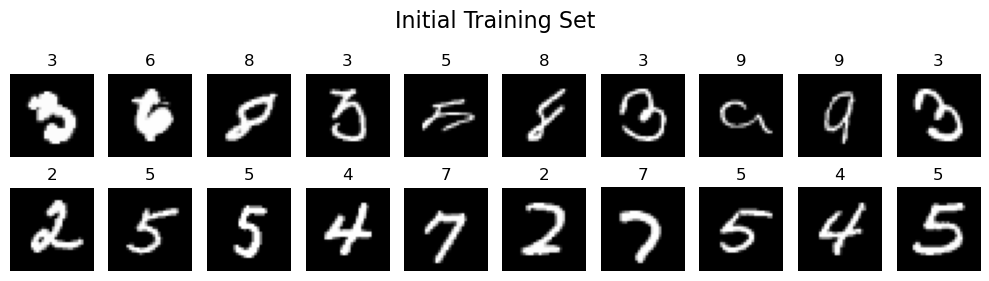

In [119]:
# plt.imshow(mutual_infos.T, cmap='hot', interpolation='nearest', aspect=10)
# plt.yticks(range(10))
# plt.show()

most_informative_idx = torch.topk(mutual_infos, 10).indices
least_informative_idx = torch.topk(-mutual_infos, 10).indices

X_most_informative = X_pool[most_informative_idx]
y_most_informative = y_pool[most_informative_idx]

X_least_informative = X_pool[least_informative_idx]
y_least_informative = y_pool[least_informative_idx]

fig, axs = plt.subplots(2, 10, figsize=(10, 3))
for i in range(10):
    ax = axs[0, i]
    ax.imshow(X_most_informative[i].squeeze(), cmap='gray')
    ax.set_title(f'{y_most_informative[i].item()}')
    ax.axis('off')
    
for i in range(10):
    ax = axs[1, i]
    ax.imshow(X_least_informative[i].squeeze(), cmap='gray')
    ax.set_title(f'{y_least_informative[i].item()}')
    ax.axis('off')
    
fig.suptitle('Initial Training Set', fontsize=16)
plt.tight_layout()
plt.show()

In [26]:
from acquisition_functions import random
from utils import visualise_most_and_least_informative_samples

vals = random(model, X_pool)
visualise_most_and_least_informative_samples(vals, X_pool, y_pool, n_least=1)

ImportError: cannot import name 'visualise_most_and_least_informative_samples' from 'utils' (/Users/pascalpilz/Library/Mobile Documents/com~apple~CloudDocs/Linz/JKU/AI Bachelor/24_1_SS/Bachelor Thesis and Practical Work/Code/ss24_bsc_project_active_learning/utils.py)